In [3]:
# ===== Import required packages =====
import pandas as pd
import bw2data as bd
import matplotlib.pyplot as plt
import pymrio as p
import matplotlib.pyplot as plt
import os
import glob
import numpy as np
import copy

# ===== Initialize Brightway25 project and load databases =====
bd.projects.set_current('brightcon') # Set the current Brightway25 project where you want to apply PB-AESA
bio = bd.Database("ecoinvent-3.10.1-biosphere")
ei = bd.Database("ecoinvent-3.10.1-cutoff")

**LCIA METHODS**

In [19]:
def create_normal_methods(biosphere_db=None):
    """
    Creates life cycle impact assessment methods for the planetary boundary categories: climate change, ocean acidification, change in biosphere integrity, phosphorus cycle, atmospheric aerosol loading, freshwater use, stratospheric ozone depletion and land-system change. 
    The life cycle impact assessment methods cover all elementary flows included in standard and prospective ecoinvent v3.10.1. Other ecoinvent version are, however, supported partially.

    Args:
        biosphere_db (database): Biosphere database from ecoinvent.
        
    Returns:
        None: LCIA methods are implemented.
    """

    # Load characterization factors for planetary boundary categories from Excel file
    file_path_characterization_factors = "Characterization Factors_for_eco3101.xlsx"
    df_pb = pd.read_excel(file_path_characterization_factors, sheet_name='Characterization Factors')
    df_pb = df_pb.iloc[1:].reset_index(drop=True)

    # Collect existing planetary boundary methods
    m = [met for met in bd.methods if "Planetary Boundaries" in str(met)]

    # Define list of planetary boundary category names
    categories = [
        "Climate Change",
        "Ocean Acidification",
        "Change in Biosphere Integrity",
        "Phosphorus Cycle",
        "Atmospheric Aerosol Loading",
        "Freshwater Use",
        "Stratospheric Ozone Depletion",
        "Land-system Change"
    ]

    # Define corresponding units for each planetary boundary category
    units = {
        "Climate Change": "Energy imbalance at top-of-atmosphere [W/m²]",
        "Ocean Acidification": "Aragonite saturation state [Ωₐᵣₐ]",
        "Change in Biosphere Integrity": "Biodiversity Intactness Index [%]",
        "Phosphorus Cycle": "P-flow from freshwater systems into the ocean [Tg P/year]",
        "Atmospheric Aerosol Loading": "Aerosol optical depth (AOD) [-]",
        "Freshwater Use": "Consumptive bluewater use [km³/year]",
        "Stratospheric Ozone Depletion": "Stratospheric ozone concentration [DU]",
        "Land-system Change": "Land available for anthropogenic occupation [millon km²]"
    }

    # Iterate over each category to create and register LCIA methods
    for cat in categories:
        
        method_key = ('Planetary Boundaries', cat)  # Define method key as (framework, category)

        if method_key not in m:
            my_method = bd.Method(method_key) # Initialize Brightway25 Method object

            myLCIAdata = [] # Initialize list to store LCIA data

            # Collect characterization factors for the current category
            for index, row in df_pb.iterrows(): 
                myLCIAdata.append([(biosphere_db.name, row['Code']), row[cat]])

            # Register and write the method to Brightway25
            my_method.validate(myLCIAdata)
            my_method.register()
            my_method.write(myLCIAdata)
            bd.methods[method_key]["unit"] = units[cat] # Assign correct unit
            bd.methods.flush() # Save changes to methods database

    # ------------------------------------------------------------------------------
    # Display all LCIA methods for the Planetary Boundary Framework
    # ------------------------------------------------------------------------------

    m = [met for met in bd.methods if "Planetary Boundaries" in str(met)]

    print("The following planetary boundary categories are now available as LCIA-methods:")
    for method in m:
        print(f"- {method}")

    return None

In [6]:
def create_n_supply_flow(biosphere_db=None):
    """
    Creates new elementary flow for nitrogen supplied to soil of agricultural systems.

    Args:
        biosphere_db (database): Biosphere database from ecoinvent.
        
    Returns:
        new_bf: Biosphere Flow for N-supply to soil.
    """

    # Add new dummy biosphere flow for nitrogen supplied to an agricultural system, if it doesn't already exist
    if ('ecoinvent-3.10.1-biosphere', 'N_supply') not in bio:
        new_bf_data_N = bio.new_activity(
            code = "N_supply",
            name = "N",
            type = "emission",
            categories = ("soil",),
            unit ="kilogram",        
        )

        new_bf_data_N.save() # Register the new nitrogen flow in the biosphere database
    else:
        print("N-supply elementary flows already exists in biopshere!")

    # Retrieve the newly created (or existing) nitrogen flow
    new_bf = bd.get_activity((biosphere_db.name, "N_supply"))
    return new_bf

In [7]:
def add_n_supply_flow_to_foreground_system(biosphere_db=None, process_ids=[]):
    """
    Adds elementary flow of N-supply to soil to custom processes in the foreground-system.

    Args:
        biosphere_db (database): Biosphere database from ecoinvent.
        process_ids (list): List of codes that identify custom processes in their respective database.
        
    Returns:
        None: N-supply flow added to processes.
    """
    
    new_bf = create_n_supply_flow(biosphere_db)
    
    for db_name in bd.databases:
        db = bd.Database(db_name)
        for id in process_ids:
            rev_N = [act for act in db if id in act['code']][0] # Retrieve activity

            # Check if the nitrogen flow is already included
            exchangeN = [exc for exc in rev_N.exchanges() if 'biosphere' in exc['type'] and exc['input'] == (biosphere_db, 'N_supply')]


            if len(exchangeN)<1:
                # Add nitrogen flow exchange if not present
                rev_N.new_exchange(input=new_bf,amount=1,type='biosphere').save()
                rev_N.save()
                exchangeN = [exc for exc in rev_N.exchanges() if 'biosphere' in exc['type'] and exc['input'] == (biosphere_db, 'N_supply')]  
                print('N-flow added to {} - {}. Exchanges: {}'.format(rev_N['reference product'],rev_N['name'],len(exchangeN)))
            else:
                print('N-flow already added to {} - {}. Exchanges: {}'.format(rev_N['reference product'],rev_N['name'],len(exchangeN)))

        return None         

In [8]:
def add_n_supply_flow_to_databases(biosphere_db=None):
    """
    Adds elementary flow of N-supply to soil to all processes that supply nitrogen to agricultural systems that are not custom processes.

    Args:
        biosphere_db (database): Biosphere database from ecoinvent.
        
    Returns:
        None: N-supply flow added to processes.
    """
    new_bf = create_n_supply_flow(biosphere_db)

    for db_name in bd.databases:
        db = bd.Database(db_name)
        # Step 1: Identify eccoinvent processes (fertiliser supply systems)
        n_search = [act for act in db if 'nutrient' in act['name']]

        if not n_search:
            continue
        
        all_supply = pd.DataFrame(n_search)

        # Filter for relevant nitrogen fertiliser types
        options = ['inorganic nitrogen fertiliser, as N', 'organic nitrogen fertiliser, as N']
        N = all_supply[all_supply['reference product'].isin(options)]

        # Step 2: Add dummy nitrogen flow to each of the identified processes
        for index, n in N.iterrows():
            act_ID = n['code']  # Use activity code as unique identifier
            rev_N = [act for act in db if act_ID in act['code']][0] # Retrieve activity

            # Check if the nitrogen flow is already included
            exchangeN = [exc for exc in rev_N.exchanges() if 'biosphere' in exc['type'] and exc['input'] == (biosphere_db, 'N_supply')]


            if len(exchangeN)<1:
                # Add nitrogen flow exchange if not present
                rev_N.new_exchange(input=new_bf,amount=1,type='biosphere').save()
                rev_N.save()
                exchangeN = [exc for exc in rev_N.exchanges() if 'biosphere' in exc['type'] and exc['input'] == (biosphere_db, 'N_supply')]  
                print('N-flow added to {} - {}. Exchanges: {}'.format(rev_N['reference product'],rev_N['name'],len(exchangeN)))
            else:
                print('N-flow already added to {} - {}. Exchanges: {}'.format(rev_N['reference product'],rev_N['name'],len(exchangeN)))

        return None         

In [9]:
def add_n_supply_flow(biosphere_db=None, process_ids=[]):
    """
    Adds elementary flow of N-supply to soil to all processes that supply nitrogen to agricultural systems.

    Args:
        biosphere_db (database): Biosphere database from ecoinvent.
        process_ids (list): List of codes that identify custom processes in their respective database.
        
    Returns:
        None: N-supply flow added to processes.
    """
    add_n_supply_flow_to_foreground_system(biosphere_db, process_ids)
    add_n_supply_flow_to_databases(biosphere_db)

    return None

In [10]:
def create_n_cycle_method(biosphere_db=None, process_ids=[]):
    """
    Creates and registers the LCIA method for the nitrogen cycle

    Args:
        biosphere_db (database): Biosphere database from ecoinvent.
        process_ids (list): List of codes that identify custom processes in their respective database.

    Returns:
        None: LCIA method is implemented.        
    """
    
    # Add N-supply elementary flow to all processes that supply nitrogen to agricultural systems
    add_n_supply_flow(biosphere_db, process_ids)

    # Define unit for LCIA method
    units = {"Nitrogen Cycle": "Industrial and intentional biological fixation of N [Tg N/year]"}   
    
    # Define the method key for the nitrogen cycle
    method_key = ('Planetary Boundaries', 'Nitrogen Cycle')
    if method_key not in m:
        my_method = bd.Method(method_key)

        # Link the dummy nitrogen flow to its characterization factor (value converts kg to Tg)
        myLCIAdata = [[('ecoinvent-3.10.1-biosphere', 'N_supply'), 0.000000001]]

        # Register and write the LCIA method
        my_method.validate(myLCIAdata)
        my_method.register()
        bd.methods[method_key]["unit"] = units["Nitrogen Cycle"]  # Assign correct unit
        my_method.write(myLCIAdata)
        bd.methods.flush() # Commit method to database

    # ------------------------------------------------------------------------------
    # Display all LCIA methods for the Planetary Boundary Framework
    # ------------------------------------------------------------------------------

    m = [met for met in bd.methods if "Planetary Boundaries" in str(met)]

    print("The following planetary boundary categories are now available as LCIA-methods:")
    for method in m:
        print(f"- {method}")

    return None

In [11]:
def create_pbaesa_methods(biosphere_db=None, process_ids=[]):
    """
    Creates and registers LCIA methods for all global planetary boundary categories except novel entities.

    Args:
        biosphere_db (database): Biosphere database from ecoinvent.
        process_ids (list): List of codes that identify custom processes in their respective database.

    Returns:
        None: LCIA methods are implemented.        
    """
    create_n_cycle_method(biosphere_db, process_ids=[])
    create_normal_methods(biosphere_db)

    return None

In [12]:
def calculate_exploitation_of_SOS(mlca_scores):
    """
    Calculates the exploitation of the Safe Operating Space (SOS) for each
    planetary boundary category based on LCIA scores.

    Parameters:
        mlca_scores (dict): Dictionary with LCIA method keys as keys and impact scores as values.

    Returns:
        dict: A dictionary with method keys and their normalized SOS exploitation values.
    """
    # Define the Safe Operating Space thresholds for each category (based on PB framework)
    safe_operating_space = {
        "Climate Change": float("1"),
        "Ocean Acidification": float("0.688"),
        "Change in Biosphere Integrity": float("10"),
        "Phosphorus Cycle": float("10"),
        "Nitrogen Cycle": float("62"),
        "Atmospheric Aerosol Loading": float("0.11"),
        "Freshwater Use": float("4000"),
        "Stratospheric Ozone Depletion": float("14.5"),
        "Land-system Change": float("85.1")
    }

    exploitation_of_SOS = {}
    for key, value in mlca_scores.items():
        category = key[0][1]  # Extract planetary boundary category from method key
        divisor = safe_operating_space.get(category)
        if divisor:  # Only compute if the category has a defined threshold
            exploitation_of_SOS[key] = value / divisor
        else:
            exploitation_of_SOS[key] = None  # Assign None if no threshold is defined

    return exploitation_of_SOS

In [13]:
def plot_exploitation_of_SOS(exploitation_of_SOS):
    """
    Plots a bar chart of the exploitation of the Safe Operating Space for each
    planetary boundary category.

    Parameters:
        exploitation_of_SOS (dict): Dictionary of SOS exploitation values.
    """
    # Extract labels (categories) and values (normalized impacts)
    labels = [key[0][1] for key in exploitation_of_SOS.keys()]
    values = list(exploitation_of_SOS.values())

    # Create bar plot
    plt.figure(figsize=(12, 6))
    plt.bar(labels, values)
    plt.xlabel('Earth-system process')
    plt.ylabel('Exploitation of Safe Operating Space')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    return None

**ALLOCATION FACTORS**

- missing to consider save_index separately
- missing doc-strings
- missing GVA-part
- missing Dummy examples
- include in Git also presentation from Brightcon for further instruction!
- let co-pilot run

In [ ]:
def get_all_allocation_factor(geographical_scope, sector, year):
    """
    Get all allocation factors for a sector in a specific geographical scope and for a specific year.

    Parameters:
        geographical_scope: str
        sector: str
        year: int

    Returns:
        filtered_df: A dataframe including the allocation factors for sector in geographical scope and specified year.

    """    
    
    directory = "Allocation Factors"
    pattern = os.path.join(directory, f'*_{year}.xlsx')
    matching_file = glob.glob(pattern)
  
    if matching_file:
        file_path_allocation_factors = matching_file[0]
        allocation_factor_df = pd.read_excel(file_path_allocation_factors)

        geo_scope_col = "Country (c.f. ISO 3166-1 alpha-2) \n& Rest of World regions"
        sector_col = "Sector (c.f. EU’s NACE Rev.1 classification)"

        if geographical_scope not in allocation_factor_df[geo_scope_col].values:
            print("Invalid location. Available options:")
            print(allocation_factor_df[geo_scope_col].unique())
            return None

        if sector not in allocation_factor_df[sector_col].values:
            print("Invalid sector. Available options:")
            print(allocation_factor_df[sector_col].unique())
            return None

        filtered_df = allocation_factor_df[
            (allocation_factor_df[geo_scope_col] == geographical_scope) &
            (allocation_factor_df[sector_col] == sector)
        ]

        return filtered_df
    else:
        print("Calculation of allocation factors necessary!")
        return None  

In [15]:
def get_direct_FCE_allocation_factor(geographical_scope, sector, year):
    filtered_df = get_all_allocation_factor(geographical_scope, sector, year)
    af_direct_fce = filtered_df['Allocation factors calculated \nvia direct final consumption expenditure'].values[0]

    return af_direct_fce

def get_total_FCE_allocation_factor(geographical_scope, sector, year):
    filtered_df = get_all_allocation_factor(geographical_scope, sector, year)
    af_total_fce = filtered_df['Allocation factors calculated \nvia total final consumption expenditure'].values[0]

    return af_total_fce

def get_direct_GVA_allocation_factor(geographical_scope, sector, year):
    filtered_df = get_all_allocation_factor(geographical_scope, sector, year)
    af_direct_gva = filtered_df['Allocation factors calculated \nvia direct gross value added'].values[0]

    return af_direct_gva

def get_total_GVA_allocation_factor(geographical_scope, sector, year):
    filtered_df = get_all_allocation_factor(geographical_scope, sector, year)
    ag_total_gva = filtered_df['Allocation factors calculated \nvia total gross value added'].values[0]

    return ag_total_gva

In [16]:
def download_exiobase_data(year):
    exio_storage_folder = os.path.abspath("./exiobase")
    exio_downloadlog = p.download_exiobase3(
        storage_folder=exio_storage_folder, system="ixi", years=[year]
    )
    return exio_downloadlog 

In [ ]:
def load_matrices(year, return_L=True, return_Y=True):

    exio_storage_folder = os.path.abspath("./exiobase")
    pattern = os.path.join(exio_storage_folder, f'IOT_{year}_*.zip')
    matching_files = glob.glob(pattern)

    if matching_files:
        exio_file_path = matching_files[0]
    else:
        download_exiobase_data(year)
        matching_files = glob.glob(pattern)
        if matching_files:
            exio_file_path = matching_files[0]
        else:
            print("Exiobase versions only exist from 1995 to 2022! Choose another")
    
    exio3 = p.parse_exiobase3(exio_file_path)

    #### Extract A-Matrix and Y-Matrix from Exiobase #### 
    A = exio3.A.copy() 
    Y = exio3.Y.copy()
    Y = Y.reset_index() 

    #### Calculate Leontief-Matrix L (c.f. Equation 2 of Oosterhoff et al.) ####
    L = p.calc_L(A)

    #### Delete not further needed variables to liberate storage ####
    del A

    results = []
    if return_L:
        results.append(L)
    if return_Y:
        results.append(Y)
    return results if len(results) > 1 else results[0]

In [23]:
def define_scope(year, return_what='all'):
    """
    Define geographical scope and sector information for a given year.

    Parameters
    ----------
    year : int or str
        Year of the dataset to load.
    return_what : str, optional
        Specify what to return. Options:
            - 'all' (default): returns (num_geo, num_sectors, geo)
            - 'num_geo': returns only the number of geographical regions
            - 'num_sectors': returns only the number of sectors
            - 'geo': returns only the list of geographical abbreviations
    """
    L = load_matrices(year, return_Y=False)

    # Define abbreviations used in Exiobase for all geographical scopes
    geo = [
        'AT', 'BE', 'BG', 'CY', 'CZ', 'DE', 'DK', 'EE', 'ES', 'FI', 'FR', 'GR', 'HR',
        'HU', 'IE', 'IT', 'LT', 'LU', 'LV', 'MT', 'NL', 'PL', 'PT', 'RO', 'SE', 'SI',
        'SK', 'GB', 'US', 'JP', 'CN', 'CA', 'KR', 'BR', 'IN', 'MX', 'RU', 'AU', 'CH',
        'TR', 'TW', 'NO', 'ID', 'ZA', 'WA', 'WL', 'WE', 'WF', 'WM'
    ]

    num_geo = len(geo)
    num_sectors = len(L)

    # Handle return options
    if return_what == 'num_geo':
        return num_geo
    elif return_what == 'num_sectors':
        return num_sectors
    elif return_what == 'geo':
        return geo
    elif return_what == 'all':
        return num_geo, num_sectors, geo
    else:
        raise ValueError(f"Invalid return_what value: {return_what}. Choose from 'all', 'num_geo', 'num_sectors', 'geo'.")




In [ ]:
def calculate_FR_matrix(year):
    
    Y = load_matrices(year, return_L=False)

    num_geo, num_sectors, geo = define_scope(year, return_what="all")

    
    #### Calculation of Equation 1 ####
    
    # Step 1: Calculate total final consumption expenditure per geographical scope
    FCE_tot_dict = {} 
    for geo_scope in geo:
        Y_geo_scope = Y[geo_scope]
        FCE_geo_scope = Y_geo_scope.iloc[:, :3].sum().sum()
        FCE_tot_dict[geo_scope] = FCE_geo_scope

    print("Final Consumption Expenditure per geographical scope calculated!")

    # Step 2: Calculate final consumption expenditure for each sector within each geographical scope (j)
    FCE_j_dict = {}

    for geo_scope in geo:
        for i in range(len(Y)):
            Y_row = Y.iloc[[i]][[geo_scope, "region", "sector"]]
            Y_row.columns = ['_'.join(col) for col in Y_row.columns]

            joint_string_1 = f"{geo_scope}_Final consumption expenditure by households"
            joint_string_2 = f"{geo_scope}_Final consumption expenditure by non-profit organisations serving households (NPISH)"
            joint_string_3 = f"{geo_scope}_Final consumption expenditure by government"

            Y_filter_FCE = Y_row[[joint_string_1, joint_string_2, joint_string_3]]
            FCE_j = Y_filter_FCE.iloc[0].sum()

            geoscope = Y_row.at[i, 'region_']
            sector = Y_row.at[i, 'sector_']
            reg_sec = (geo_scope, geoscope, sector)

            FCE_j_dict[reg_sec] = FCE_j

    print("Final Consumption Expenditure per sector within geographical scope calculated!")

    # Step 3: Compute FRj,r matrix (sector in geographical scope share of FCE per geographical scope)
    relative_FCE_dict = {}
    for target_geo_scope in geo:
        total_FCE = FCE_tot_dict[target_geo_scope]
        values_with_metadata = [(geoscope, sector, value) for (geo_scope, geoscope, sector), value in FCE_j_dict.items() if geo_scope == target_geo_scope]
        rel_FCE_with_metadata = [(geoscope, sector, value / total_FCE) for geoscope, sector, value in values_with_metadata]
        relative_FCE_dict[target_geo_scope] = rel_FCE_with_metadata

    # Create MultiIndex dataframe for FR matrix
    unique_geoscopes_sectors = set()
    for data in relative_FCE_dict.values():
        for geoscope, sector, _ in data:
            unique_geoscopes_sectors.add((geoscope, sector))

    unique_geoscopes_sectors = sorted(list(unique_geoscopes_sectors))

    df = pd.DataFrame(index=pd.MultiIndex.from_tuples(unique_geoscopes_sectors, names=["geoscope", "Sector"]))

    for geo_scope, data in relative_FCE_dict.items():
        geo_scope_data = { (geoscope, sector): rel_FCE for geoscope, sector, rel_FCE in data }
        df[geo_scope] = pd.Series(geo_scope_data)

    # Convert to matrix and check shape    
    FR_matrix = (
        df.transpose()
        .rename(columns=lambda col: '_'.join(col))
        .sort_index()
        .transpose()
        .sort_index()
        .to_numpy()
    ) 


    assert FR_matrix.shape == (num_sectors, num_geo), "FR_matrix shape mismatch!"

    # Delete not further needed variables to liberate storage
    del FCE_j_dict, Y

    return FR_matrix

In [22]:
def calculate_population_weights():
    #### Calculation of Equation 9 ####

    sPOPr_dict = {
        "AT": 0.001137112, "BE": 0.001469619, "BG": 0.000813057, "CY": 0.000157388,
        "CZ": 0.001342135, "DE": 0.010538512, "DK": 0.000742371, "EE": 0.000169631,
        "ES": 0.006008648, "FI": 0.000698741, "FR": 0.008548135, "GR": 0.001311299,
        "HR": 0.000484889, "HU": 0.001212719, "IE": 0.000644798, "IT": 0.007412402,
        "LT": 0.00035611,  "LU": 8.21348E-05,  "LV": 0.000236353, "MT": 6.67933E-05,
        "NL": 0.002226092, "PL": 0.004630737, "PT": 0.001309134, "RO": 0.002395369,
        "SE": 0.001318847, "SI": 0.000265605, "SK": 0.000683102, "GB": 0.008525459,
        "US": 0.041912521, "JP": 0.015735834, "CN": 0.177596435, "CA": 0.004897012,
        "KR": 0.00649839,  "BR": 0.027078025, "IN": 0.17822501,  "MX": 0.016035037,
        "RU": 0.01813937,  "AU": 0.003271595, "CH": 0.001103648, "TR": 0.010687152,
        "TW": 0.003004855, "NO": 0.000686293, "ID": 0.034647303, "ZA": 0.00753231,
        "WA": 0.121196918797013, "WL": 0.039809986, "WE": 0.0204874844768778, "WF": 0.144929024082053,
        "WM": 0.0618275302286748
    } #Dictionary that includes shares of global population by geographical scope for the year 2022

    sorted_geo = sorted(sPOPr_dict.keys())
    sPOPr = np.squeeze(np.array([sPOPr_dict[geo_scope] for geo_scope in sorted_geo]))

    return sPOPr

In [ ]:
def calculate_direct_FCE_allocation_factor(year):
    FR_matrix = calculate_FR_matrix(year)
    sPOPr = calculate_population_weights()
    direct_FCE_pop = (FR_matrix * sPOPr).sum(axis=1)
    direct_FCE_pop_df = pd.DataFrame(direct_FCE_pop, columns=["direct_FCE"])
    direct_FCE_pop_df.index = save_index
    
    return direct_FCE_pop_df

In [ ]:
def calculate_indirect_FCE_allocation_factor(year):

    
    FR_matrix = calculate_FR_matrix(year)
    L = load_matrices(year, return_Y=False)
    num_geo, num_sectors, geo = define_scope(year)
    sPOPr = calculate_population_weights()

    #### Calculation of Equation 3 ####
    L_T = np.transpose(L)
    e = np.ones((len(L_T), 1))
    S_roof_pre = np.dot(L_T, e)
    I = np.identity(len(L_T))
    S_roof = np.multiply(S_roof_pre, I)

    #### Calculation of Equation 5 ####
    L_diag = np.multiply(L, I)
    L_dif = L - L_diag
    L_dif_T = np.transpose(L_dif)
    f_top = np.dot(L_dif_T, e)
    f_bottom = np.dot(L_diag, e)
    f = f_top / f_bottom

    #### Calculation of Equation 4 ####
    e_T = np.transpose(e)
    f_scalar = np.dot(f, e_T)
    L_f = np.multiply(L, f_scalar)
    S_tilde = L + L_f

    #### Calculation of Equation 6 ####
    S = S_roof + S_tilde

    #### Calculation of Equation 7 ####
    S_roof_div = np.linalg.inv(S_roof) 
    S_marginal = np.matmul(S,S_roof_div)
    S_marginal_T = S_marginal.transpose()
    S_marginal_T.columns = ['_'.join(col) for col in S_marginal_T.columns]
    S_marginal_T.index = S_marginal_T.columns
    S_marginal_T = S_marginal_T.sort_index()
    S_marginal = S_marginal_T.transpose()
    S_marginal = S_marginal.sort_index() 
    save_index = S_marginal.index
    S_marginal = S_marginal.to_numpy()

    aSoSOS_j_i_r = np.zeros((num_sectors, num_sectors, num_geo))

    for r in range(num_geo):
        FR_vector = FR_matrix[:, r].reshape((num_sectors, 1))
        aSoSOS_j_i_r[:, :, r] = S_marginal * FR_vector

    #### Calculation of Equation 8 ####
    aSoSOS_j_r = aSoSOS_j_i_r.sum(axis=1) # aSoSOS_j_r is total share assigned to sector j based on the overall final demand for sector i in geographical scope r ###########

    aSoSOS_j = (aSoSOS_j_r * sPOPr).sum(axis=1)
    indirect_FCE_df = pd.DataFrame(aSoSOS_j, columns=["Allocation factor calculated via total final consumption expenditure"])
    indirect_FCE_df.index = save_index

    # Delete not further needed variables to liberate storage
    del L_T, L_diag, L_dif, L_dif_T, L_f, S_tilde, f_scalar, I, S_roof_div, S_roof, S_marginal_T, S, S_marginal, aSoSOS_j_i_r

    return indirect_FCE_df

In [ ]:
def calculate_allocation_factors(year):
    direct_FCE_df = calculate_direct_FCE_allocation_factor(year)
    indirect_FCE_df = calculate_indirect_FCE_allocation_factor(year)

    aSoSOS_j_df = pd.DataFrame()
    aSoSOS_j_df["Allocation factor calculated via total final consumption expenditure"] = indirect_FCE_df["Allocation factor calculated via total final consumption expenditure"]
    aSoSOS_j_df['Allocation factor calculated via direct final consumption expenditure'] = direct_FCE_df['direct_FCE']


    return aSoSOS_j_df

**DUMMY LCA**

In [35]:
my_allocation_factor = get_all_allocation_factor("DE", "Cultivation of wheat", 2022)
my_allocation_factor

,Country (c.f. ISO 3166-1 alpha-2) \n& Rest of World regions,Sector (c.f. EU’s NACE Rev.1 classification),Allocation factors calculated \nvia direct final consumption expenditure,Allocation factors calculated \nvia total final consumption expenditure,Allocation factors calculated \nvia direct gross value added,Allocation factors calculated \nvia total gross value added
1654,DE,Cultivation of wheat,0.000012,0.000027,0.000008,0.000016


In [ ]:
import bw2calc as bc

m = [met for met in bd.methods if "Planetary Boundaries" in str(met)]

dummy_process = [act for act in ei if 'DE' in act ['location'] and 'wheat grain production' in act ['name']][0]


functional_unit = {
    "dummy_process": {ei.get(dummy_process["code"]).id: 22.6 * 10e9},
}
config = {
    "impact_categories": m
}
data_objs = bd.get_multilca_data_objs(functional_units=functional_unit, method_config=config)

mlca = bc.MultiLCA(demands=functional_unit, method_config=config, data_objs=data_objs)
mlca.lci()
mlca.lcia()
mlca_scores = mlca.scores

exploit = calculate_exploitation_of_SOS(mlca_scores)


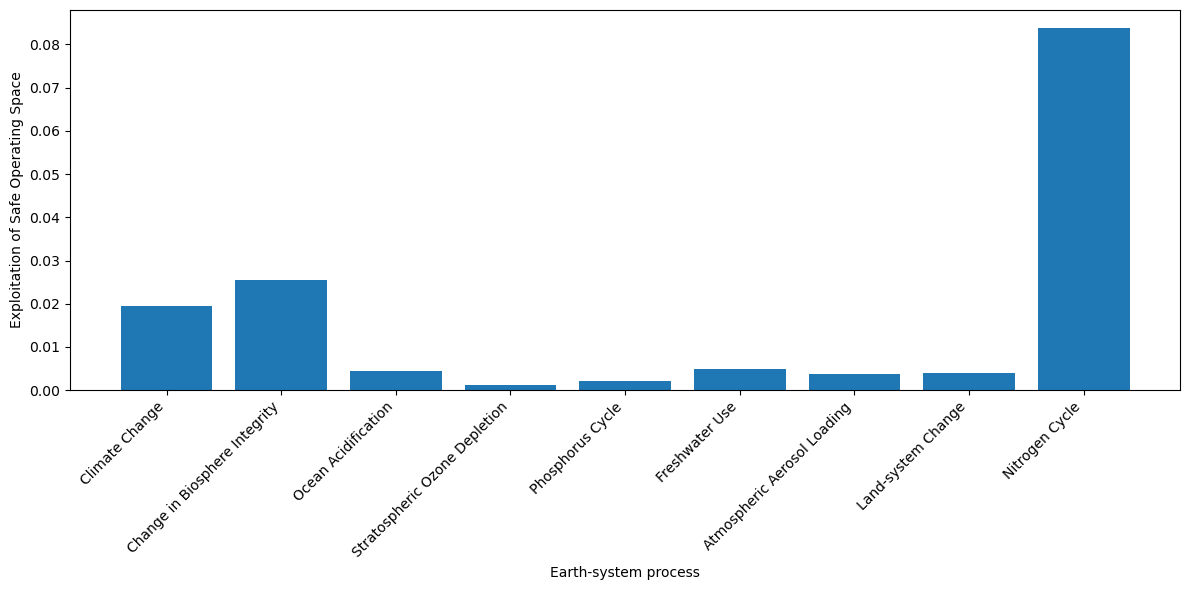

In [ ]:
plot_exploitation_of_SOS(exploit)